## 0. Import Libraries

In [1]:
# ====================================================================
# STEP 0: Import Libraries
# ====================================================================
# 과제에 사용할 library들을 import

# 시스템 및 입출력 관련
import os  # 디렉토리, 파일 경로 조작 등
from PIL import Image  # 이미지 열기 및 처리 (Pillow)
from tqdm import tqdm  # 반복문의 진행 상태 시각화
from pathlib import Path  # payhon path


# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화 
import matplotlib
# 한글 폰트 설정 (Windows의 기본 한글 폰트)
matplotlib.rc('font', family='Malgun Gothic')
# 마이너스 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns  # 고급 시각화 (히트맵, 스타일 등)

# 이미지 처리
import cv2  # OpenCV - 고급 이미지/비디오 처리

# 수치 연산
import numpy as np  # 배열, 벡터 계산 등

# PyTorch 기본 구성
import torch  # 텐서, 연산 등
import torch.nn as nn  # 모델 정의 (layer, loss 등)
import torch.nn.functional as F
import torch.optim as optim  # Optimizer (SGD, Adam 등)

# PyTorch 데이터 처리
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋, 배치 로딩

# PyTorch 이미지 전처리
import torchvision
from torchvision import transforms  # 기본 이미지 transform
from torchvision import datasets  # torchvision 내장 데이터셋
import torchvision.models as models

from torchvision.transforms import v2  # torchvision v2 transforms (최신 API)

# 싸이킷런 평가 지표
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# 싸이킷런 데이터 나누기
from sklearn.model_selection import train_test_split

# 통계 tool
import pandas as pd

# 실험 추적 및 하이퍼파라미터 관리
# import wandb  # Weights & Biases - 실험 로깅, 시각화, 하이퍼파라미터 튜닝

# Garbage Collector 모듈
# import gc

# Data Augmentation 패키지: Albumentations
import albumentations as A

import json

## 1. Set configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


device를 확인해보면 cpu로 나오는데 이전에 한 스프린트 미션 9를 로컬로 돌려보면 colab cpu보다 빠르게 연산이 됩니다.
화요일에 환경 설정을 하면서 cuda를 설치했는데 다시 한번 확인해봐야겠습니다.

## 2. Data pre-processing

In [3]:
DATA_ROOT = Path("/Users/user/myproject/AI03-Project-1/data/raw")
train_image_dir = DATA_ROOT / "train_images"
train_ann_path = DATA_ROOT / "train_annotations"
test_image_dir = DATA_ROOT / "test_images"

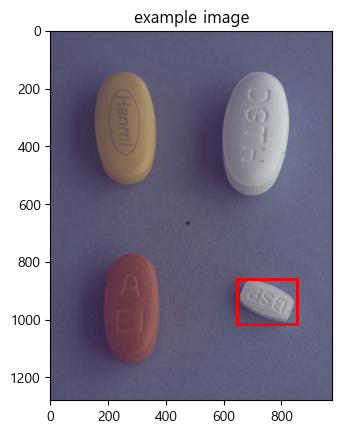

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

image_name = "K-001900-010224-016551-031705_0_2_0_2_70_000_200"

def draw_bbox(image_path, bbox):
    image = Image.open(train_image_dir / f"{image_name}.png").convert("RGB")
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    x, y, w, h = bbox

    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title("example image")
    plt.show()


draw_bbox(f"train_image_dir/{image_name}.png", [645, 859, 210, 158]) # x,y,w,h

예시 이미지에 바운딩 박스를 그려 매칭이 잘 되는지 확인해봤습니다.

In [5]:
# transform
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])) # bbox 형식은 pascal_voc: [xmin, ymin, xmax, ymax]

valtest_transforms = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [6]:
# 시각화용 역정규화 
def unnormalize(image_tensor, mean, std):
    # image_tensor: [C, H, W]
    image_tensor = image_tensor.clone()
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

시각화할 때 원본 이미지로 볼 방법으로, 역정규화를 하는 함수를 만들었습니다. 
이 외에도 데이터셋을 생성할 때, 원본 데이터셋과 transform을 적용한 데이터셋을 구분해 생성하는 방법도 있겠습니다.

In [7]:
# from collections import defaultdict

# def parse_all_annotations(annotation_root):
#     annotations_dict = defaultdict(lambda: {'boxes': [], 'labels': []})
#     category_id_to_name = {}

#     for dirpath, _, filenames in os.walk(annotation_root):
#         for fname in filenames:
#             if fname.endswith('.json'):
#                 json_path = os.path.join(dirpath, fname)
#                 with open(json_path, 'r', encoding='utf-8') as f:
#                     data = json.load(f)

#                 # 카테고리 정보 저장
#                 for cat in data['categories']:
#                     category_id_to_name[cat['id']] = cat['name']

#                 image_info = data['images'][0]
#                 image_id = image_info['id']
#                 file_name = image_info['file_name']

#                 for ann in data['annotations']:
#                     x, y, w, h = ann['bbox']
#                     bbox = [x, y, x + w, y + h]
#                     category_id = ann['category_id']

#                     annotations_dict[file_name]['boxes'].append(bbox)
#                     annotations_dict[file_name]['labels'].append(category_id)

#     return annotations_dict, category_id_to_name

In [8]:
# from collections import defaultdict

# def parse_all_annotations(annotation_root):
#     annotations_dict = defaultdict(lambda: {'boxes': [], 'labels': []})
#     category_id_to_name = {}

#     for dirpath, _, filenames in os.walk(annotation_root):
#         for fname in filenames:
#             if fname.endswith('.json'):
#                 json_path = os.path.join(dirpath, fname)
#                 with open(json_path, 'r', encoding='utf-8') as f:
#                     data = json.load(f)

#                 for cat in data['categories']:
#                     category_id_to_name[cat['id']] = cat['name']

#                 image_info = data['images'][0]
#                 file_name = image_info['file_name']
#                 img_w = image_info.get('width', 1024)  # width 정보 없으면 기본값 사용
#                 img_h = image_info.get('height', 1024)

#                 for ann in data['annotations']:
#                     x, y, w, h = ann['bbox']
#                     x1 = max(0, x)
#                     y1 = max(0, y)
#                     x2 = min(x + w, img_w)
#                     y2 = min(y + h, img_h)

#                     # 박스가 비정상적인 경우 출력 후 continue
#                     if x2 <= x1 or y2 <= y1:
#                         print(f"[무시됨] 파일: {fname} | 이미지: {file_name}")
#                         print(f" → 원래 bbox: x={x}, y={y}, w={w}, h={h}")
#                         print(f" → 클리핑 후: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]\n")
#                         continue

#                     bbox = [x1, y1, x2, y2]
#                     category_id = ann['category_id']

#                     annotations_dict[file_name]['boxes'].append(bbox)
#                     annotations_dict[file_name]['labels'].append(category_id)

#     return annotations_dict, category_id_to_name

In [9]:
# # 어노테이션 저장

# annotations_dict, category_id_to_name = parse_all_annotations(train_ann_path)

In [10]:
# from collections import Counter

# # 모든 라벨을 리스트로 모은다
# all_labels = [annotations_dict[k]['labels'][0] for k in annotations_dict]

# # 라벨의 분포 확인
# label_counter = Counter(all_labels)

In [11]:
# from collections import Counter

# print(f"총 이미지 수: {len(annotations_dict)}")
# print(f"카테고리 총 개수 : {len(category_id_to_name)}")
# print("카테고리 이름 및 개수:")
# for category_id, count in label_counter.items():
#     category_name = category_id_to_name.get(category_id, 'Unknown')
#     print(f"{category_id} : {category_name}, {count}개")

총 이미지 수, 카테고리 수, 카테고리 목록을 먼저 출력하고 카테고리 목록별 개수를 출력하는 코드를 작성했으나 둘을 셀 하나에 합침

In [12]:
# category_ids = sorted(set([cat_id for cat_id in category_id_to_name.keys()]))
# category_id_to_label = {cat_id: idx + 1 for idx, cat_id in enumerate(category_ids)}

In [13]:
# print(category_id_to_label)

In [14]:
# from collections import defaultdict

# def parse_all_annotations2(annotation_root):
#     annotations_dict = defaultdict(lambda: {'boxes': [], 'labels': []})
#     category_id_to_name = {}

#     for dirpath, _, filenames in os.walk(annotation_root):
#         for fname in filenames:
#             if fname.endswith('.json'):
#                 json_path = os.path.join(dirpath, fname)
#                 with open(json_path, 'r', encoding='utf-8') as f:
#                     data = json.load(f)

#                 for cat in data['categories']:
#                     category_id_to_name[cat['id']] = cat['name']

#                 image_info = data['images'][0]
#                 file_name = image_info['file_name']
#                 img_w = image_info.get('width', 1024)  # width 정보 없으면 기본값 사용
#                 img_h = image_info.get('height', 1024)

#                 for ann in data['annotations']:
#                     x, y, w, h = ann['bbox']
#                     x1 = max(0, x)
#                     y1 = max(0, y)
#                     x2 = min(x + w, img_w)
#                     y2 = min(y + h, img_h)

#                     # 박스가 비정상적인 경우 출력 후 continue
#                     if x2 <= x1 or y2 <= y1:
#                         print(f"[무시됨] 파일: {fname} | 이미지: {file_name}")
#                         print(f" → 원래 bbox: x={x}, y={y}, w={w}, h={h}")
#                         print(f" → 클리핑 후: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]\n")
#                         continue

#                     bbox = [x1, y1, x2, y2]
#                     category_id = ann['category_id']

#                     annotations_dict[file_name]['boxes'].append(bbox)
#                     annotations_dict[file_name]['labels'].append(category_id)

#     return annotations_dict, category_id_to_name

# # 어노테이션 저장
# annotations_dict, category_id_to_name = parse_all_annotations2(train_ann_path)

In [15]:

# # 모든 라벨을 리스트로 모은다
# all_labels = [label for k in annotations_dict for label in annotations_dict[k]['labels']]

# # 라벨의 분포 확인
# label_counter = Counter(all_labels)

# for image_id in annotations_dict:
#     annotations_dict[image_id]['labels'] = [
#         category_id_to_label[cat_id] for cat_id in annotations_dict[image_id]['labels']
#     ]

# print(f"총 이미지 수: {len(annotations_dict)}")
# print(f"카테고리 총 개수: {len(category_id_to_name)}")
# print("카테고리 이름 및 개수:")
# for category_id, count in label_counter.items():
#     label = category_id_to_label.get(category_id, 'Unknown')
#     category_name = category_id_to_name.get(category_id, "Unknown")
#     print(f"{label} : {category_name}, {count}개")

In [16]:
from collections import defaultdict, Counter

def parse_all_annotations(annotation_root):
    annotations_dict = defaultdict(lambda: {'boxes': [], 'labels': [], 'original_labels': []})
    category_id_to_name = {}

    # 전체 category_id → name
    for dirpath, _, filenames in os.walk(annotation_root):
        for fname in filenames:
            if fname.endswith('.json'):
                json_path = os.path.join(dirpath, fname)
                with open(json_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                for cat in data['categories']:
                    category_id_to_name[cat['id']] = cat['name']

                image_info = data['images'][0]
                file_name = image_info['file_name']
                img_w = image_info.get('width', 1024)
                img_h = image_info.get('height', 1024)

                for ann in data['annotations']:
                    x, y, w, h = ann['bbox']
                    x1 = max(0, x)
                    y1 = max(0, y)
                    x2 = min(x + w, img_w)
                    y2 = min(y + h, img_h)

                    if x2 <= x1 or y2 <= y1:
                        print(f"[무시됨] 파일: {fname} | 이미지: {file_name}")
                        print(f" → 원래 bbox: x={x}, y={y}, w={w}, h={h}")
                        print(f" → 클리핑 후: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]\n")
                        continue

                    bbox = [x1, y1, x2, y2]
                    category_id = ann['category_id']

                    annotations_dict[file_name]['boxes'].append(bbox)
                    annotations_dict[file_name]['original_labels'].append(category_id)

    return annotations_dict, category_id_to_name

In [17]:
annotations_dict, category_id_to_name = parse_all_annotations(train_ann_path)

[무시됨] 파일: K-003351-016262-018357_0_2_0_2_75_000_200.json | 이미지: K-003351-016262-018357_0_2_0_2_75_000_200.png
 → 원래 bbox: x=6567, y=625, w=311, h=315
 → 클리핑 후: [6567.0, 625.0, 976.0, 940.0]

[무시됨] 파일: K-003544-004543-012247-016551_0_2_0_2_70_000_200.json | 이미지: K-003544-004543-012247-016551_0_2_0_2_70_000_200.png
 → 원래 bbox: x=653, y=8889, w=217, h=217
 → 클리핑 후: [653.0, 8889.0, 870.0, 1280.0]



In [18]:
# 정렬된 category_id 목록
category_ids = sorted(set([cat_id for cat_id in category_id_to_name.keys()]))

# category_id → label_index (1부터 시작)
category_id_to_label = {cat_id: idx + 1 for idx, cat_id in enumerate(category_ids)}
label_to_category_id = {v: k for k, v in category_id_to_label.items()}  # 역방향도 만들어둠

In [19]:
# 정수형 라벨을 따로 저장
for image_id in annotations_dict:
    annotations_dict[image_id]['labels'] = [
        category_id_to_label[cat_id] for cat_id in annotations_dict[image_id]['original_labels']
    ]

In [36]:
# 라벨 분포 (original category_id 기준)
all_original_labels = [label for k in annotations_dict for label in annotations_dict[k]['original_labels']]
label_counter = Counter(all_original_labels)

print(f"총 이미지 수: {len(annotations_dict)}")
print(f"카테고리 총 개수: {len(category_id_to_name)}")
print("카테고리 이름 및 개수:")
for category_id, count in label_counter.items():
    label_index = category_id_to_label.get(category_id, 'Unknown')
    category_name = category_id_to_name.get(category_id, 'Unknown')
    print(f"{label_index}({category_id}) : {category_name}, {count}개")

총 이미지 수: 1489
카테고리 총 개수: 73
카테고리 이름 및 개수:
1(1899) : 보령부스파정 5mg, 180개
24(16550) : 동아가바펜틴정 800mg, 139개
60(31704) : 낙소졸정 500/20mg, 35개
64(33008) : 신바로정, 35개
23(16547) : 가바토파정 100mg, 143개
26(18109) : 란스톤엘에프디티정 30mg, 24개
36(21025) : 펠루비정(펠루비프로펜), 35개
52(27925) : 울트라셋이알서방정, 38개
55(29344) : 비모보정 500/20mg, 38개
56(29450) : 레일라정, 34개
31(19606) : 스토가정 10mg, 32개
38(21770) : 라비에트정 20mg, 29개
45(24849) : 놀텍정 10mg, 27개
65(33207) : 에스원엠프정 20mg, 30개
73(44198) : 케이캡정 50mg, 30개
2(2482) : 뮤테란캡슐 100mg, 172개
6(3742) : 알드린정, 54개
8(4377) : 타이레놀정500mg, 33개
12(6191) : 삐콤씨에프정 618.6mg/병, 34개
18(12777) : 다보타민큐정 10mg/병, 36개
30(19551) : 트루비타정 60mg/병, 39개
42(22626) : 메가파워정 90mg/병, 36개
44(23222) : 비타비백정 100mg/병, 38개
11(5885) : 타이레놀이알서방정(아세트아미노펜)(수출용), 35개
15(12080) : 리렉스펜정 300mg/PTP, 35개
19(13394) : 써스펜8시간이알서방정 650mg, 34개
41(22361) : 맥시부펜이알정 300mg, 36개
10(5093) : 삼남건조수산화알루미늄겔정, 56개
47(25437) : 큐시드정 31.5mg/PTP, 61개
3(3350) : 일양하이트린정 2mg, 240개
7(3831) : 뉴로메드정(옥시라세탐), 27개
21(16231) : 리피토정 20mg, 109개
22(16261) : 크레스토정 20mg

In [21]:
from sklearn.model_selection import train_test_split

# 전체 이미지 파일 목록
all_images = list(annotations_dict.keys())

# 80% 학습, 20% 검증 분할
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

In [22]:
import os
import json
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset

class PillDetectionDataset(Dataset):
    def __init__(self, image_dir, annotations_dict, transforms=None):
        self.image_dir = image_dir
        self.annotations_dict = annotations_dict
        self.image_files = list(annotations_dict.keys())
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert("RGB")

        boxes = torch.tensor(self.annotations_dict[image_file]['boxes'], dtype=torch.float32)
        labels = torch.tensor(self.annotations_dict[image_file]['labels'], dtype=torch.int64)

        if self.transforms:
            transformed = self.transforms(
                image=np.array(image),
                bboxes=boxes.numpy().astype(np.float32),
                labels=labels.numpy().tolist()
            )
            image = transformed["image"]
            boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
            labels = torch.tensor(transformed["labels"], dtype=torch.int64)
            
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }
        return image, target
    

In [23]:
for k, v in list(annotations_dict.items())[:3]:  # 처음 3개 항목 출력
    print(f"Key: {k}")
    print(f"Value: {v}")

Key: K-001900-010224-016551-031705_0_2_0_2_70_000_200.png
Value: {'boxes': [[645, 859, 855, 1017], [566, 131, 851, 581], [134, 123, 379, 549]], 'labels': [1, 24, 60], 'original_labels': [1899, 16550, 31704]}
Key: K-001900-010224-016551-031705_0_2_0_2_75_000_200.png
Value: {'boxes': [[128, 258, 324, 406], [109, 648, 397, 1144]], 'labels': [1, 24], 'original_labels': [1899, 16550]}
Key: K-001900-010224-016551-031705_0_2_0_2_90_000_200.png
Value: {'boxes': [[144, 264, 347, 412], [142, 701, 429, 1178], [617, 735, 871, 1183]], 'labels': [1, 24, 60], 'original_labels': [1899, 16550, 31704]}


In [24]:
class PillTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.image_dir = image_dir
        self.image_files = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert("RGB")

        if self.transforms:
            transformed = self.transforms(image=np.array(image))
            image = transformed['image']

        return image, image_file  # 이미지와 파일 이름을 함께 반환 (예측 결과 저장 시 필요)

In [25]:
# Train용 annotations_dict
train_dict = {img: annotations_dict[img] for img in train_imgs}

# Val용 annotations_dict
val_dict = {img: annotations_dict[img] for img in val_imgs}

# Dataset 생성
train_dataset = PillDetectionDataset(image_dir=train_image_dir, annotations_dict=train_dict, transforms=train_transforms)
val_dataset   = PillDetectionDataset(image_dir=train_image_dir, annotations_dict=val_dict, transforms=valtest_transforms)
test_dataset = PillTestDataset(image_dir=test_image_dir, transforms=valtest_transforms)

In [26]:
print(f"훈련 데이터 개수 : {len(train_dataset)}")
print(f"검증 데이터 개수 : {len(val_dataset)}")
print(f"테스트 데이터 개수 : {len(test_dataset)}")

훈련 데이터 개수 : 1191
검증 데이터 개수 : 298
테스트 데이터 개수 : 843


In [27]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [28]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [29]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

298
75
211


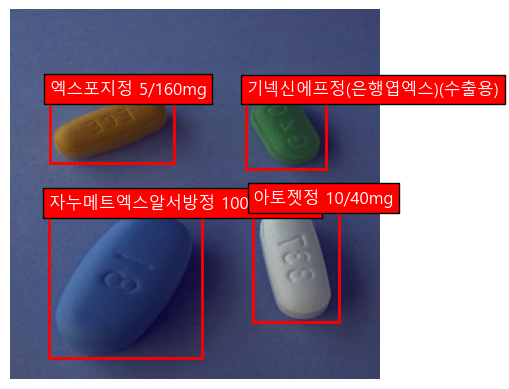

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 이미지 하나 꺼냄
images, targets = next(iter(train_loader))

# 첫 번째 이미지 및 타겟
example_image = images[0]
example_target = targets[0]

# Normalize 해제 (만약 normalize 했을 경우만)
image_vis = unnormalize(example_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
image_vis = image_vis.permute(1, 2, 0).numpy()

# 시각화 시작
fig, ax = plt.subplots(1)
ax.imshow(image_vis)

# 바운딩 박스 및 라벨 표시
for box, label in zip(example_target['boxes'], example_target['labels']):
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin

    category_id = label.item()
    original_category_id = label_to_category_id.get(category_id, category_id)
    category_name = category_id_to_name.get(original_category_id, f"ID:{original_category_id}")

    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin, category_name, color='white', fontsize=12, bbox=dict(facecolor='red'))

plt.axis('off')
plt.show()

## 3. Model implementation

In [31]:
num_classes = len(category_id_to_name) + 1
print(num_classes)

74


In [32]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # 사전 학습된 Faster R-CNN 모델 로드
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # 기존 head를 num_classes에 맞게 교체
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [33]:
model = get_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
def visualize_prediction(image_tensor, prediction, label_to_category_id, category_id_to_name, score_threshold=0.5):
    # 이미지 복원 (normalize 해제)
    def unnormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor

    image_vis = unnormalize(image_tensor.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    image_vis = image_vis.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image_vis)

    boxes = prediction['boxes']
    labels = prediction['labels']
    scores = prediction['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score < score_threshold:
            continue  # confidence가 낮으면 skip

        xmin, ymin, xmax, ymax = box.cpu().numpy()
        width = xmax - xmin
        height = ymax - ymin

        # 라벨 → 카테고리 ID → 이름
        label_int = label.item()
        category_id = label_to_category_id.get(label_int, label_int)
        category_name = category_id_to_name.get(category_id, f"ID:{category_id}")

        ax.add_patch(patches.Rectangle((xmin, ymin), width, height,
                                       linewidth=2, edgecolor='lime', facecolor='none'))
        ax.text(xmin, ymin - 5, f"{category_name} ({score:.2f})",
                color='white', fontsize=10, backgroundcolor='green')

    plt.axis('off')
    plt.show()

100%|██████████| 298/298 [02:10<00:00,  2.29it/s]


[Epoch 1] Loss: 244.5629


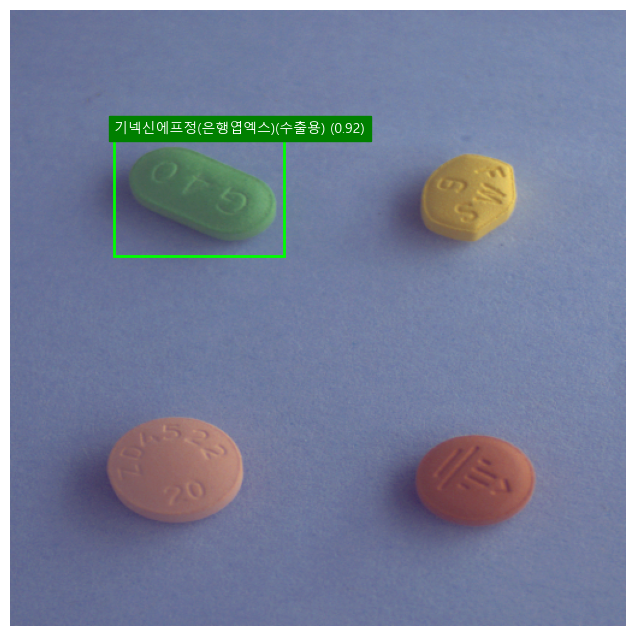

100%|██████████| 298/298 [02:09<00:00,  2.30it/s]


[Epoch 2] Loss: 116.9950


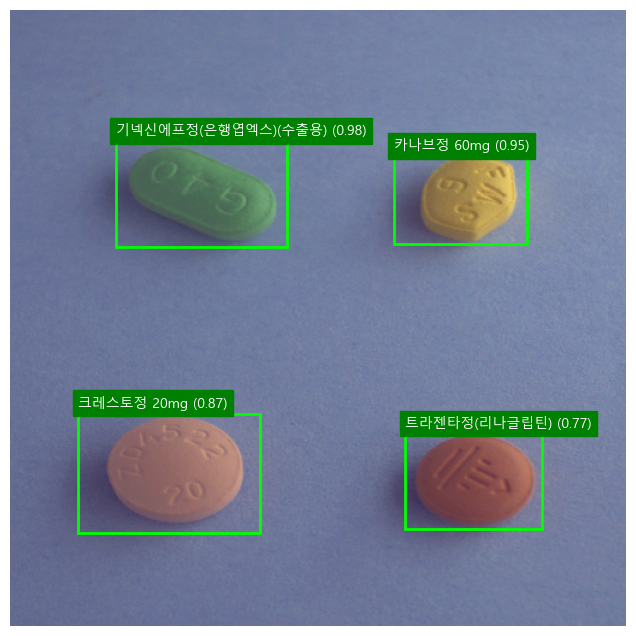

100%|██████████| 298/298 [02:09<00:00,  2.29it/s]


[Epoch 3] Loss: 68.6551


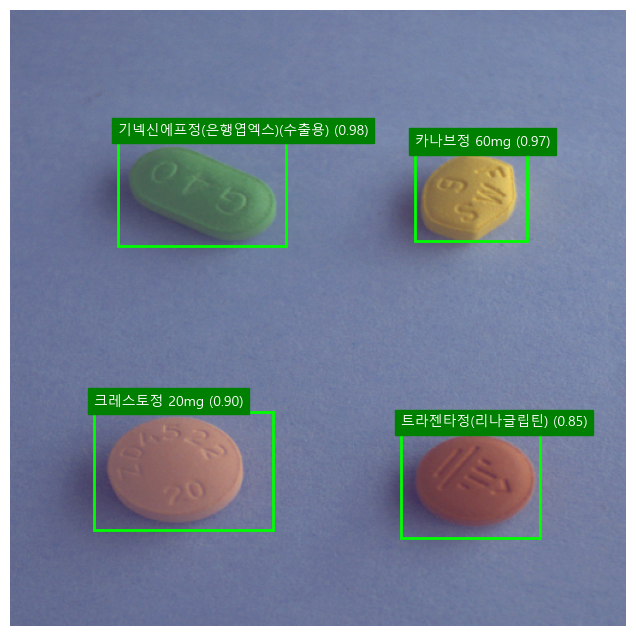

100%|██████████| 298/298 [02:09<00:00,  2.30it/s]


[Epoch 4] Loss: 37.8435


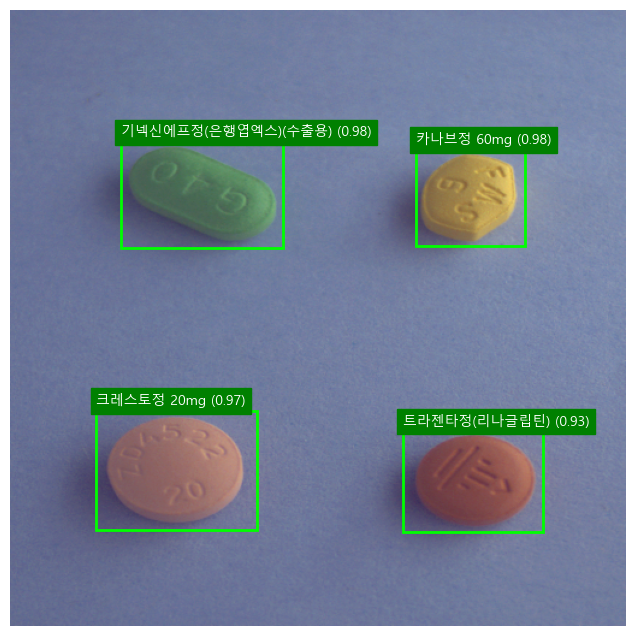

100%|██████████| 298/298 [02:10<00:00,  2.28it/s]


[Epoch 5] Loss: 31.6751


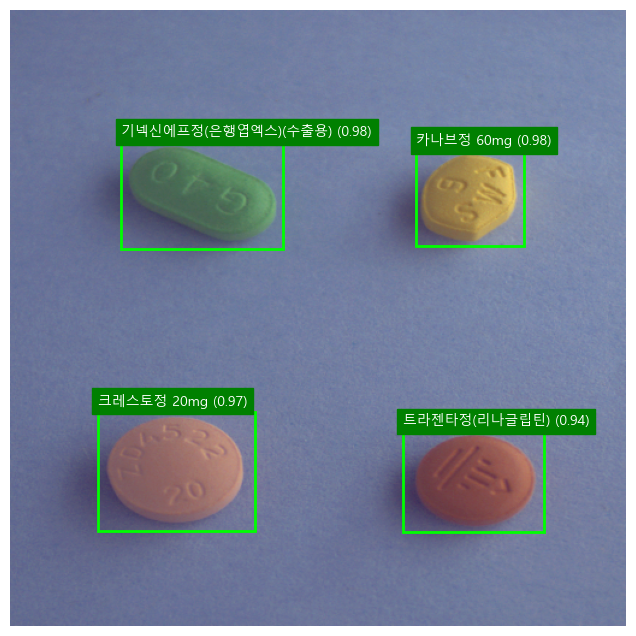

In [35]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

    lr_scheduler.step()

    # ======== 검증 ========
    model.eval()
    with torch.no_grad():
        images, targets = next(iter(val_loader))
        images = [img.to(device) for img in images]

        outputs = model(images)  # 추론 결과

        # 한 장만 시각화
        visualize_prediction(
            image_tensor=images[0].cpu(),
            prediction=outputs[0],
            label_to_category_id=label_to_category_id,
            category_id_to_name=category_id_to_name,
            score_threshold=0.5  # 원하는 confidence threshold 설정
        )